# Environment

In [11]:
!python -m pip install --upgrade pip setuptools wheel

In [12]:
!pip install --upgrade tensorflow==2.19.1 keras==3.6.0 ml-dtypes==0.5.1 keras-hub --only-binary=:all:

  Using cached keras-3.6.0-py3-none-any.whl.metadata (5.8 kB)
INFO: pip is looking at multiple versions of keras-hub to determine which version is compatible with other requirements. This could take a while.
  Using cached keras_hub-0.22.2-py3-none-any.whl.metadata (7.4 kB)
  Using cached keras_hub-0.22.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached keras_hub-0.22.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached keras_hub-0.21.1-py3-none-any.whl.metadata (7.4 kB)
Using cached keras-3.6.0-py3-none-any.whl (1.2 MB)
Using cached keras_hub-0.21.1-py3-none-any.whl (876 kB)
  Attempting uninstall: keras
    Found existing installation: keras 3.11.3
    Uninstalling keras-3.11.3:
      Successfully uninstalled keras-3.11.3
  Attempting uninstall: keras-hub━━━━━━━━━━━━━━━ 0/2 [keras]
    Found existing installation: keras-hub 0.22.20/2 [keras]
    Uninstalling keras-hub-0.22.2:90m╺━━━━━━━━━━━━━━━━━━━ 1/2 [keras-hub]
      Successfully uninstalled keras-hub-0.22.2━━━━━━━━━━━━━━━ 1/2 [ke

In [13]:
!pip install wordcloud keras-cv keras-nlp tfclip tensorflow-hub keras-hub keras tensorflow-text

  Using cached keras_hub-0.22.2-py3-none-any.whl.metadata (7.4 kB)
  Using cached keras-3.11.3-py3-none-any.whl.metadata (5.9 kB)
Using cached keras_hub-0.22.2-py3-none-any.whl (947 kB)
Using cached keras-3.11.3-py3-none-any.whl (1.4 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.6.0
    Uninstalling keras-3.6.0:
      Successfully uninstalled keras-3.6.0
  Attempting uninstall: keras-hub━━━━━━━━━━━━━━━ 0/2 [keras]
    Found existing installation: keras-hub 0.21.10/2 [keras]
    Uninstalling keras-hub-0.21.1:━━━━━━━━━━ 0/2 [keras]
      Successfully uninstalled keras-hub-0.21.1m 0/2 [keras]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [keras-hub]/2 [keras-hub]


In [15]:
!pip install tensorflow-text

In [20]:
import os, json, hashlib, random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud, STOPWORDS

print("TF:", tf.__version__)

TF: 2.16.2


In [21]:
# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


# Paths & Load data

In [22]:
DATA_DIR = "./A2_Data"
JSONL   = os.path.join(DATA_DIR, "A2_train_v3.jsonl")
IMAGE_DIR = os.path.join(DATA_DIR, "A2_Images")
df = pd.read_json(JSONL, lines=True)
assert set(["Image_ID","Label","Hypothesis","Premise"]).issubset(df.columns), df.columns

# Resolve image paths (try common extensions)
EXTS = [".jpg", ".jpeg", ".png", ".JPG", ".PNG"]
def resolve_image_path(image_id, root=IMAGE_DIR, exts=EXTS):
    sid = str(image_id).strip()
    for e in exts:
        p = os.path.join(root, sid + e)
        if os.path.isfile(p):
            return p
    return None


In [23]:
df["image_path"] = df["Image_ID"].apply(resolve_image_path)
missing_before = df["image_path"].isna().sum()
if missing_before:
    print(f"[WARN] {missing_before} rows have no matching image file. Dropping them.")
df = df.dropna(subset=["image_path"]).reset_index(drop=True)


# Exploratory Data Analysis

In [24]:
import os, re, math, random, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageOps

# Optional deep EDA (text+image similarity)
DO_DEEP_SIM = True
try:
    import tensorflow as tf, tensorflow_hub as hub, tensorflow_text  # noqa
    import keras_hub as kh
except Exception:
    DO_DEEP_SIM = False
    print("[INFO] Deep similarity (USE/CLIP) disabled — missing TF deps. Install if you want those plots.")

# -----------------------
# Config
# -----------------------
DATA_FILE   = "./A2_Data/train.csv"     # accepts .csv, .tsv, .jsonl
IMAGE_ROOT  = "./A2_Data/A2_Images"
SEED = 42
random.seed(SEED); np.random.seed(SEED)


[INFO] Deep similarity (USE/CLIP) disabled — missing TF deps. Install if you want those plots.


In [25]:
# Optional deep EDA (text+image similarity)
import os

def count_images(root_dir, exts=None, show_breakdown=True):
    """
    Recursively count image files in `root_dir`.

    Args:
        root_dir (str): Path to scan.
        exts (list[str] | None): Allowed extensions (case-insensitive).
                                 Defaults to common image formats.
        show_breakdown (bool): Whether to print counts per extension.

    Returns:
        total (int): Total number of image files found.
    """
    if exts is None:
        exts = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif", ".webp"]

    # Normalize to lowercase for matching
    exts = [e.lower() for e in exts]
    counts = {e: 0 for e in exts}
    total = 0

    for root, _, files in os.walk(root_dir):
        for f in files:
            _, ext = os.path.splitext(f)
            ext = ext.lower()
            if ext in exts:
                counts[ext] += 1
                total += 1

    if show_breakdown:
        print(f"\nImage counts under: {root_dir}")
        for e, c in counts.items():
            print(f"  {e:>6}: {c}")
        print(f"  Total: {total}")

    return total

total = count_images(IMAGE_ROOT)
print(f"\nTotal images found: {total}")



Image counts under: ./A2_Data/A2_Images
    .jpg: 19573
   .jpeg: 0
    .png: 0
    .bmp: 0
   .tiff: 0
    .gif: 0
   .webp: 0
  Total: 19573

Total images found: 19573


In [26]:
df["Label"] = df["Label"].astype(str).str.strip().str.lower()
valid_labels = {"entailment","contradiction","neutral"}
unknown = set(df["Label"].unique()) - valid_labels
if unknown:
    print("[WARN] Found unknown labels:", unknown)

# Stable label map
label_names = sorted([l for l in df["Label"].unique() if l in valid_labels])
label2id = {n:i for i,n in enumerate(label_names)}
df["label_id"] = df["Label"].map(label2id)

In [27]:
def show_bar(series, title, xlabel, ylabel="Count", rot=45, figsize=(7,4)):
    plt.figure(figsize=figsize)
    series.plot(kind="bar")
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.xticks(rotation=rot); plt.tight_layout(); plt.show()

def simple_tokenize(s):
    return [t for t in re.split(r"[^a-z0-9]+", str(s).lower()) if t]

def negation_count(s):
    # crude but useful: captures typical negation cues
    terms = ["no","not","never","none","nobody","nothing","nowhere","neither","nor","cannot","can't","won't","n't"]
    toks = simple_tokenize(s)
    return sum(tok in terms for tok in toks)


[EDA] Label distribution
Label
entailment       19619
contradiction    19510
Name: count, dtype: int64


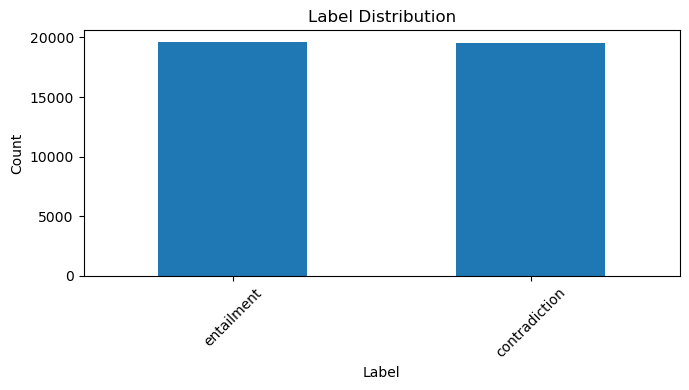

Imbalance ratio (max/min): 1.01


In [28]:
print("\n[EDA] Label distribution")
lbl_counts = df["Label"].value_counts()
print(lbl_counts)
show_bar(lbl_counts, "Label Distribution", "Label")
print(f"Imbalance ratio (max/min): {lbl_counts.max()/max(1,lbl_counts.min()):.2f}")

In [29]:
print("\n[EDA] Conflicting labels for the SAME Image_ID")
conflict_counts = (
    df.groupby("Image_ID")["Label"]
      .nunique()
      .reset_index(name="n_labels")
      .query("n_labels > 1")
)
print(f"Images with multiple labels: {len(conflict_counts)}")
if len(conflict_counts):
    # Show a few examples with all their rows
    sample_ids = conflict_counts["Image_ID"].head(3).tolist()
    print("\nExamples (first 3 Image_IDs with conflicts):")
    print(df[df["Image_ID"].isin(sample_ids)]
          .sort_values(["Image_ID","Label"])
          [["Image_ID","Label","Hypothesis","Premise"]]
          .head(12)
          .to_string(index=False))


[EDA] Conflicting labels for the SAME Image_ID
Images with multiple labels: 8945

Examples (first 3 Image_IDs with conflicts):
 Image_ID         Label                                        Hypothesis                                                                                                           Premise
    36979 contradiction      The students are walking down a busy street.                                                  A group of college students gathers to play texas hold em poker.
    36979    entailment                       People playing a card game.                   A group of friends playing cards and trying to bluff each other into making a terrible mistake.
   178045 contradiction A crowd watches at the magician performs his act.                                                A group of traditional Mexican dancers twirl their flowing skirts.
   178045    entailment     A group of dancers are twirling their skirts.                                               

### Duplicates Leakage Check

In [30]:
import pandas as pd
from tqdm import tqdm
import hashlib

# 1️⃣ Compute MD5 hashes if you haven’t already
def md5_file(path, chunk_size=8192):
    try:
        h = hashlib.md5()
        with open(path, "rb") as f:
            while chunk := f.read(chunk_size):
                h.update(chunk)
        return h.hexdigest()
    except Exception as e:
        return None  # missing / unreadable file

if "image_md5" not in df.columns:
    tqdm.pandas(desc="Hashing images")
    df["image_md5"] = df["image_path"].astype(str).progress_apply(md5_file)

# 2️⃣ Find groups of identical hashes with different Image_IDs
dupe_groups = (
    df.groupby("image_md5")
      .agg({"Image_ID": pd.Series.nunique, "image_path": list})
      .reset_index()
)

# Keep only those where multiple Image_IDs share same hash
dupe_groups = dupe_groups[dupe_groups["Image_ID"] > 1]

print(f"🧩 Found {len(dupe_groups)} duplicate hash groups (same image, different ID)")

# 3️⃣ For each hash, print which Image_IDs share it
for _, row in dupe_groups.iterrows():
    md5 = row["image_md5"]
    # subset rows that share this hash
    subset = df[df["image_md5"] == md5][["Image_ID", "image_path"]].drop_duplicates()
    print("\n🔁 Duplicate image content group:")
    print(f"Hash: {md5}")
    print(subset.to_string(index=False))

Hashing images: 100%|██████████| 39129/39129 [00:43<00:00, 899.94it/s]


🧩 Found 0 duplicate hash groups (same image, different ID)


In [31]:
import pandas as pd

# 1️⃣ Count how many times each Image_ID appears
img_counts = (
    df["Image_ID"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Image_ID", "Image_ID": "count"})
)

# 2️⃣ Keep only images used more than once
reused = img_counts[img_counts["count"] > 1]

print(f"🧩 Found {len(reused)} images used multiple times (total rows: {len(df)})")
print(reused.dropna()) 

🧩 Found 19573 images used multiple times (total rows: 39129)
            count  count
0      2572812372    3.0
1      3372351555    3.0
2      4564320256    3.0
3      3470718914    3.0
4      1931018353    3.0
...           ...    ...
13064  2494562446    2.0
13065  3936944273    2.0
13066  3135504530    2.0
13067  4329504863    2.0
13068  3209350613    2.0

[13069 rows x 2 columns]


In [32]:
import pandas as pd

# 1️⃣ Define the columns that define a "record"
#    (change these if your key is different)
key_cols = ["Image_ID", "Premise", "Hypothesis", "Label"]

# 2️⃣ Drop rows with NaN in key columns (since NaN ≠ NaN)
df_clean = df.dropna(subset=key_cols).copy()

# 3️⃣ Detect duplicates — keep=False marks *all* occurrences
df_clean["is_duplicate"] = df_clean.duplicated(subset=key_cols, keep=False)

# 4️⃣ Subset only duplicated records
duplicates_df = df_clean[df_clean["is_duplicate"]].copy()

# 5️⃣ Count unique duplicated groups
dupe_groups = (
    duplicates_df.groupby(key_cols)
    .size()
    .reset_index(name="duplicate_count")
    .sort_values("duplicate_count", ascending=False)
)

# 🧾 Summary
print(f"🧩 Total rows in df: {len(df)}")
print(f"🔁 Total duplicated rows: {len(duplicates_df)}")
print(f"📦 Unique duplicate groups: {len(dupe_groups)}")

# 6️⃣ Show top duplicate groups
print("\n🔍 Top duplicate groups (same record repeated):")
print(dupe_groups.head(10))

# 7️⃣ Optional: inspect all duplicates side by side
if not duplicates_df.empty:
    print("\n🔁 All duplicate rows (full details):")
    print(duplicates_df.sort_values(key_cols).head(20))


🧩 Total rows in df: 39129
🔁 Total duplicated rows: 2
📦 Unique duplicate groups: 1

🔍 Top duplicate groups (same record repeated):
     Image_ID                                            Premise  \
0  3389458786  Two young Asians, a girl and a boy, dressed up...   

                                 Hypothesis          Label  duplicate_count  
0  The boy and girl are wearing sweatpants.  contradiction                2  

🔁 All duplicate rows (full details):
        Image_ID          Label                                Hypothesis  \
1398  3389458786  contradiction  The boy and girl are wearing sweatpants.   
1399  3389458786  contradiction  The boy and girl are wearing sweatpants.   

                                                Premise  \
1398  Two young Asians, a girl and a boy, dressed up...   
1399  Two young Asians, a girl and a boy, dressed up...   

                              image_path  label_id  \
1398  ./A2_Data/A2_Images/3389458786.jpg         0   
1399  ./A2_Data/A2_Im

### Text stats & cues


[EDA] Text length — Premise
Chars: count    39129.00
mean        64.60
std         27.86
min         10.00
25%         45.00
50%         59.00
75%         78.00
max        339.00
Words: count    39129.00
mean        12.62
std          5.42
min          2.00
25%          9.00
50%         12.00
75%         15.00
max         64.00


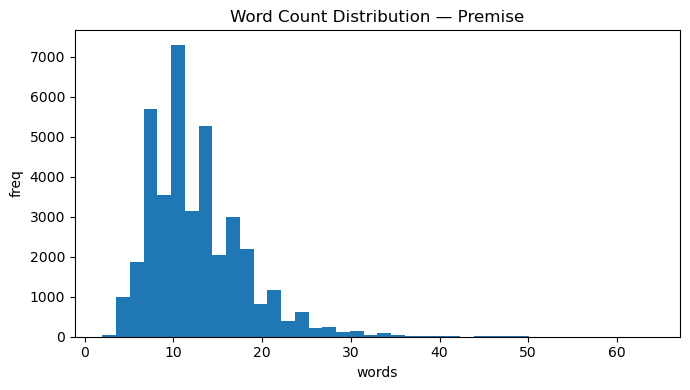


[EDA] Text length — Hypothesis
Chars: count    39129.00
mean        34.87
std         14.04
min          1.00
25%         25.00
50%         32.00
75%         41.00
max        204.00
Words: count    39129.00
mean         6.95
std          2.75
min          1.00
25%          5.00
50%          6.00
75%          8.00
max         35.00


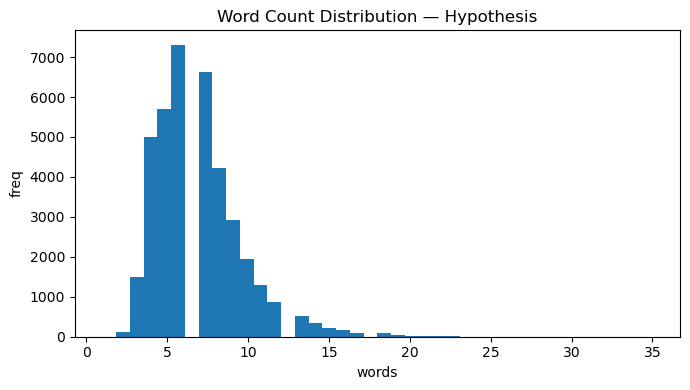

In [33]:
for col in ["Premise","Hypothesis"]:
    print(f"\n[EDA] Text length — {col}")
    lengths = df[col].astype(str).map(lambda s: len(s))
    words   = df[col].astype(str).map(lambda s: len(simple_tokenize(s)))
    print("Chars:", lengths.describe().round(2).to_string())
    print("Words:", words.describe().round(2).to_string())
    plt.figure(figsize=(7,4)); plt.hist(words, bins=40)
    plt.title(f"Word Count Distribution — {col}")
    plt.xlabel("words"); plt.ylabel("freq"); plt.tight_layout(); plt.show()


### Lexical overlap (Jaccard) between Premise and Hypothesis

In [34]:
def jaccard(a, b):
    sa, sb = set(simple_tokenize(a)), set(simple_tokenize(b))
    if not sa and not sb: return 0.0
    return len(sa & sb) / max(1, len(sa | sb))

In [35]:
df["lex_jaccard_prem_hypo"] = [
    jaccard(p, h) for p,h in zip(df["Premise"], df["Hypothesis"])
]
print("\n[EDA] Lexical Jaccard Premise↔Hypothesis (overall)")
print(df["lex_jaccard_prem_hypo"].describe().round(3).to_string())

print("\nPer-label mean Jaccard:")
print(df.groupby("Label")["lex_jaccard_prem_hypo"].mean().round(3).to_string())



[EDA] Lexical Jaccard Premise↔Hypothesis (overall)
count    39129.000
mean         0.237
std          0.177
min          0.000
25%          0.111
50%          0.200
75%          0.321
max          1.000

Per-label mean Jaccard:
Label
contradiction    0.189
entailment       0.285


### Negation cues (often strong for contradiction)

In [36]:
df["neg_prem"] = df["Premise"].map(negation_count)
df["neg_hypo"] = df["Hypothesis"].map(negation_count)
print("\nPer-label mean negation counts:")
print(df.groupby("Label")[["neg_prem","neg_hypo"]].mean().round(3).to_string())



Per-label mean negation counts:
               neg_prem  neg_hypo
Label                            
contradiction     0.004     0.044
entailment        0.004     0.006


### Image integrity & stats

In [37]:
print("\n[EDA] Image integrity")
corrupted = []
for p in df["image_path"]:
    try:
        with Image.open(p) as im:
            im.verify()
    except Exception as e:
        corrupted.append((p, str(e)))
print("Corrupted images:", len(corrupted))
if corrupted[:5]:
    print("Examples:", corrupted[:5])



[EDA] Image integrity
Corrupted images: 0


### Size & aspect


Image size/ratio describe:
              w         h    aspect
count  39129.00  39129.00  39129.00
mean     459.22    395.52      1.23
std       67.70     74.60      0.36
min      164.00    112.00      0.33
25%      384.00    333.00      0.77
50%      500.00    375.00      1.33
75%      500.00    500.00      1.50
max      500.00    500.00      4.46


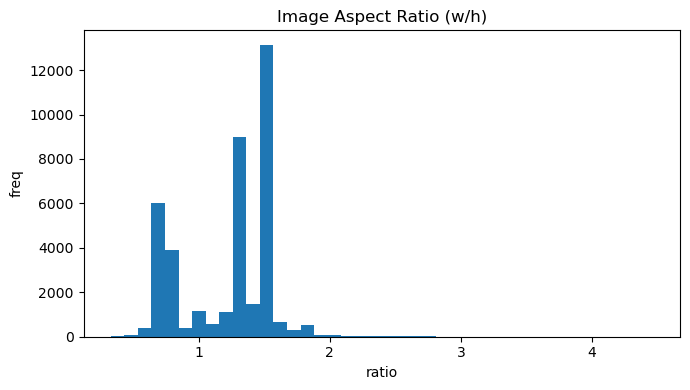

In [38]:
def size_stats(path):
    with Image.open(path) as im:
        im = ImageOps.exif_transpose(im)
        w,h = im.size
        return w,h, (w/h if h else np.nan)

rows = []
for _,r in df.iterrows():
    try:
        w,h,ar = size_stats(r["image_path"])
        rows.append({"Label": r["Label"], "w": w, "h": h, "aspect": ar})
    except Exception:
        pass
img_stats = pd.DataFrame(rows)
print("\nImage size/ratio describe:")
print(img_stats[["w","h","aspect"]].describe().round(2).to_string())

plt.figure(figsize=(7,4)); plt.hist(img_stats["aspect"].dropna(), bins=40)
plt.title("Image Aspect Ratio (w/h)"); plt.xlabel("ratio"); plt.ylabel("freq")
plt.tight_layout(); plt.show()


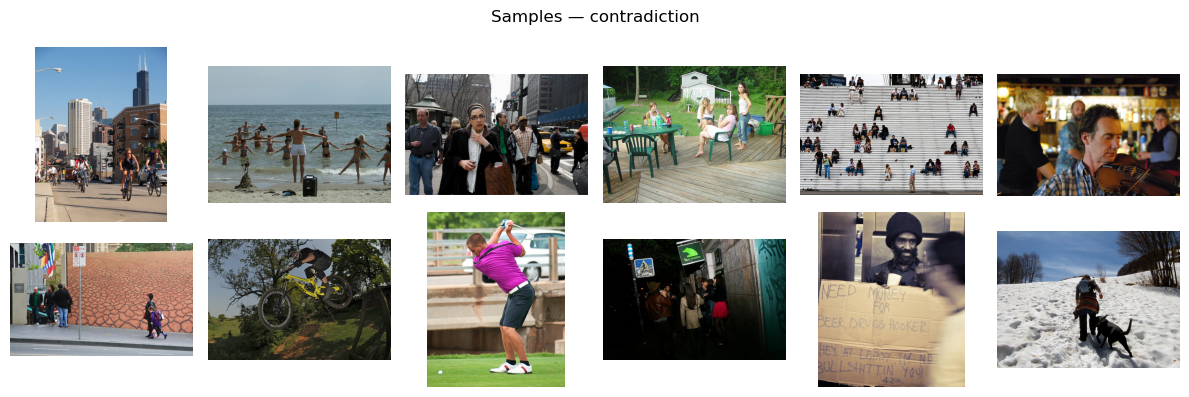

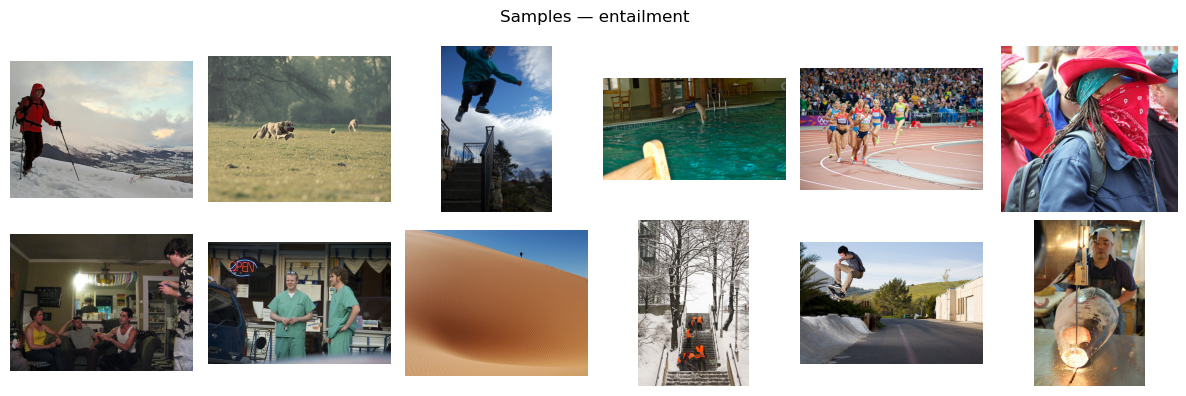

In [39]:
def montage(paths, n=12, cols=6, title="Montage"):
    paths = paths[:n]
    rows = math.ceil(len(paths)/cols) if cols else 1
    plt.figure(figsize=(cols*2, rows*2))
    for i,p in enumerate(paths):
        try:
            img = Image.open(p).convert("RGB")
            plt.subplot(rows, cols, i+1)
            plt.imshow(img); plt.axis("off")
        except: pass
    plt.suptitle(title); plt.tight_layout(); plt.show()

for lbl in label_names:
    subset = df[df["Label"]==lbl]["image_path"].sample(
        min(12, sum(df["Label"]==lbl)), random_state=SEED).tolist()
    if subset:
        montage(subset, n=len(subset), cols=6, title=f"Samples — {lbl}")


🧩 19573 unique images (from 39129 total rows)


Computing histograms: 100%|██████████| 19573/19573 [01:03<00:00, 309.06it/s]


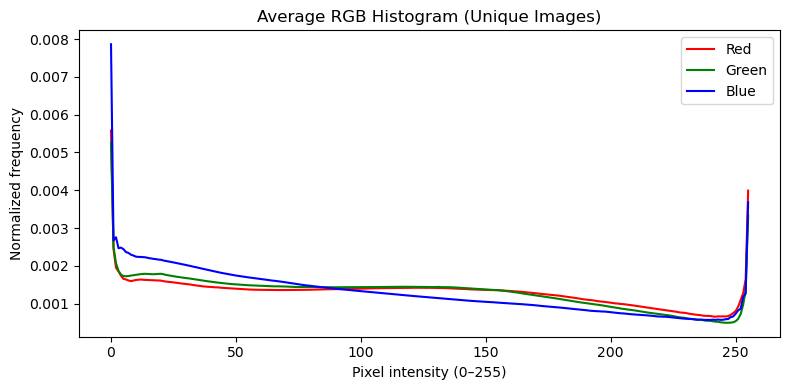

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import hashlib

# ---------- 1️⃣ Hashing helper (MD5) ----------
def md5_file(path, chunk_size=8192):
    try:
        h = hashlib.md5()
        with open(path, "rb") as f:
            while chunk := f.read(chunk_size):
                h.update(chunk)
        return h.hexdigest()
    except Exception:
        return None

# ---------- 2️⃣ Attach image_md5 if missing ----------
if "image_md5" not in df.columns:
    tqdm.pandas(desc="Hashing images")
    df["image_md5"] = df["image_path"].astype(str).progress_apply(md5_file)

# ---------- 3️⃣ Keep only unique images by hash ----------
df_unique = df.drop_duplicates(subset=["image_md5"], keep="first").dropna(subset=["image_md5"]).reset_index(drop=True)
print(f"🧩 {len(df_unique)} unique images (from {len(df)} total rows)")

# ---------- 4️⃣ Helper: load + histogram ----------
def load_image(path, color_mode="rgb"):
    img = cv2.imread(str(path))
    if img is None:
        return None
    if color_mode == "rgb":
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_mode == "gray":
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def compute_average_histogram(df, img_col="image_path", color_mode="rgb", bins=256):
    all_hists = []

    for path in tqdm(df[img_col], desc="Computing histograms"):
        img = load_image(path, color_mode=color_mode)
        if img is None:
            continue

        if color_mode == "gray":
            hist = cv2.calcHist([img], [0], None, [bins], [0,256]).flatten()
        else:
            hist_r = cv2.calcHist([img], [0], None, [bins], [0,256]).flatten()
            hist_g = cv2.calcHist([img], [1], None, [bins], [0,256]).flatten()
            hist_b = cv2.calcHist([img], [2], None, [bins], [0,256]).flatten()
            hist = np.stack([hist_r, hist_g, hist_b], axis=1)

        # Normalize per image
        hist = hist / (hist.sum() + 1e-8)
        all_hists.append(hist)

    avg_hist = np.mean(np.stack(all_hists, axis=0), axis=0)
    return avg_hist

# ---------- 5️⃣ Plot ----------
def plot_average_histogram(avg_hist, color_mode="rgb"):
    bins = np.arange(len(avg_hist))
    plt.figure(figsize=(8,4))
    if color_mode == "gray":
        plt.plot(bins, avg_hist, color="black")
        plt.title("Average Grayscale Histogram (Unique Images)")
        plt.xlabel("Pixel intensity (0–255)")
        plt.ylabel("Normalized frequency")
    else:
        plt.plot(bins, avg_hist[:,0], color="r", label="Red")
        plt.plot(bins, avg_hist[:,1], color="g", label="Green")
        plt.plot(bins, avg_hist[:,2], color="b", label="Blue")
        plt.title("Average RGB Histogram (Unique Images)")
        plt.xlabel("Pixel intensity (0–255)")
        plt.ylabel("Normalized frequency")
        plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- 6️⃣ Run ----------
avg_hist = compute_average_histogram(df_unique, img_col="image_path", color_mode="rgb", bins=256)
plot_average_histogram(avg_hist, color_mode="rgb")


### USE & CLIP similarities


[EDA] USE Premise↔Hypothesis cosine (CPU, batched)


2025-10-04 01:45:44.537089: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-04 01:45:47.440309: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-04 01:45:47.443510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

count    39129.000
mean         0.455
std          0.212
min         -0.173
25%          0.294
50%          0.444
75%          0.608
max          1.000

Per-label mean USE cosine:
Label
contradiction    0.372
entailment       0.537


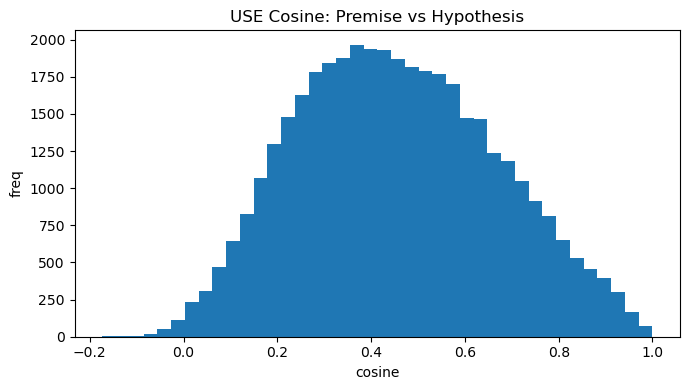

In [41]:
if True:
    # ---- SAFE USE on CPU (batched) ----
    def _chunks(lst, bsz):
        for i in range(0, len(lst), bsz):
            yield lst[i:i+bsz]

    def compute_use_embeddings_cpu(texts, batch_size=256,
                                   handle="https://tfhub.dev/google/universal-sentence-encoder/4"):
        with tf.device("/CPU:0"):
            use = hub.KerasLayer(handle, input_shape=[], dtype=tf.string, trainable=False)
            outs = []
            for chunk in _chunks(texts, batch_size):
                emb = use(tf.constant(chunk))
                outs.append(emb.numpy())   # materialize on host
            return np.concatenate(outs, axis=0).astype(np.float32)

    print("\n[EDA] USE Premise↔Hypothesis cosine (CPU, batched)")
    prem_texts = df["Premise"].astype(str).tolist()
    hypo_texts = df["Hypothesis"].astype(str).tolist()
    prem_emb_np = compute_use_embeddings_cpu(prem_texts, batch_size=256)   # (N, 512)
    hypo_emb_np = compute_use_embeddings_cpu(hypo_texts, batch_size=256)

    prem_n = prem_emb_np / np.linalg.norm(prem_emb_np, axis=1, keepdims=True)
    hypo_n = hypo_emb_np / np.linalg.norm(hypo_emb_np, axis=1, keepdims=True)
    use_diag = np.sum(prem_n * hypo_n, axis=1).astype(np.float32)

    df["use_cos_prem_hypo"] = use_diag
    print(df["use_cos_prem_hypo"].describe().round(3).to_string())
    print("\nPer-label mean USE cosine:")
    print(df.groupby("Label")["use_cos_prem_hypo"].mean().round(3).to_string())

    plt.figure(figsize=(7,4))
    plt.hist(df["use_cos_prem_hypo"], bins=40)
    plt.title("USE Cosine: Premise vs Hypothesis")
    plt.xlabel("cosine"); plt.ylabel("freq")
    plt.tight_layout(); plt.show()


In [42]:
# del hypo_emb_np

In [43]:
# # pip install tfclip opencv-python matplotlib pandas tqdm
# import os
# import numpy as np
# import pandas as pd
# import cv2
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from keras import models, ops
# from tfclip import create_model_and_transforms

# # ========== CONFIG ==========
# MODEL_NAME = "ViT-B-32-quickgelu"   # or "ViT-B-32"
# PRETRAINED = "openai"               # e.g. openai / laion400m_e31 / laion400m_e32 / metaclip_400m / metaclip_fullcc
# IMG_BATCH  = 64
# TXT_BATCH  = 256

# # ========== LOAD MODEL ==========
# model, image_prep, text_prep = create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)
# # build encoders from trained heads (unit-space before temperature)
# image_encoder = models.Model(model.inputs[0], model.get_layer("vision_head_out").output)
# text_encoder  = models.Model(model.inputs[1], model.get_layer("text_head_out").output)

# # ========== HELPERS ==========
# def _first(val):
#     """Unwrap dict outputs from preprocessors to the first tensor."""
#     if isinstance(val, dict):
#         return next(iter(val.values()))
#     return val

# def _load_rgb(path):
#     bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
#     if bgr is None:
#         raise FileNotFoundError(f"Could not read image: {path}")
#     return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# def _unit(x):
#     x = np.asarray(x)
#     denom = np.linalg.norm(x, axis=-1, keepdims=True) + 1e-8
#     return x / denom

# def _prep_one_image(p):
#     rgb = _load_rgb(p)          # HxWx3 uint8
#     x = image_prep(rgb)         # fixed-size float32 tensor
#     return _first(x)

# def _cos(a, b):  # expects unit-norm vectors
#     return float(np.dot(a, b))

# # ========== 1) IMAGE FEATURES (dedup + safe batching) ==========
# img_feats = {}
# unique_paths = df["image_path"].astype(str).unique().tolist()

# for i in tqdm(range(0, len(unique_paths), IMG_BATCH), desc="Images"):
#     paths = unique_paths[i:i+IMG_BATCH]

#     prepped_list, good_paths = [], []
#     for p in paths:
#         try:
#             prepped_list.append(_prep_one_image(p))
#             good_paths.append(p)
#         except Exception as e:
#             print(f"[warn] skipping {p}: {e}")
#     if not prepped_list:
#         continue

#     # stack & encode
#     imgs_tf = tf.stack(prepped_list, axis=0)                         # (B,H,W,3)
#     feats   = image_encoder(imgs_tf, training=False).numpy()         # (B,D)
#     feats   = _unit(feats)                                           # L2 normalize

#     for p, f in zip(good_paths, feats):
#         img_feats[p] = f

# # ========== 2) TEXT FEATURES (dedup + batching) ==========
# # Keep SEPARATE dicts to avoid overwriting (fixes your KeyError).
# txt_feats_hypo = {}
# uniq_hypo = df["Hypothesis"].astype(str).unique().tolist()
# for j in tqdm(range(0, len(uniq_hypo), TXT_BATCH), desc="Texts (hypothesis)"):
#     ts = uniq_hypo[j:j+TXT_BATCH]
#     toks = _first(text_prep(ts))
#     feats = text_encoder(toks, training=False).numpy()
#     feats = _unit(feats)
#     for t, f in zip(ts, feats):
#         txt_feats_hypo[t] = f

# txt_feats_prem = {}
# uniq_prem = df["Premise"].astype(str).unique().tolist()
# for j in tqdm(range(0, len(uniq_prem), TXT_BATCH), desc="Texts (premise)"):
#     ts = uniq_prem[j:j+TXT_BATCH]
#     toks = _first(text_prep(ts))
#     feats = text_encoder(toks, training=False).numpy()
#     feats = _unit(feats)
#     for t, f in zip(ts, feats):
#         txt_feats_prem[t] = f

# # ========== 3) COSINE SCORES per row ==========
# df = df.copy()

# # image ↔ hypothesis
# df["clip_cos_hypo"] = [
#     _cos(img_feats[str(p)], txt_feats_hypo[str(h)])
#     for p, h in tqdm(zip(df["image_path"].astype(str), df["Hypothesis"].astype(str)),
#                      total=len(df), desc="Scoring hypothesis")
# ]

# # image ↔ premise
# df["clip_cos_prem"] = [
#     _cos(img_feats[str(p)], txt_feats_prem[str(x)])
#     for p, x in tqdm(zip(df["image_path"].astype(str), df["Premise"].astype(str)),
#                      total=len(df), desc="Scoring premise")
# ]

# print(df[["Label","clip_cos_prem","clip_cos_hypo"]].head())

# # ========== 4) PLOTS ==========
# # 4a) Separate histograms (premise vs hypothesis) by label
# if "Label" in df.columns:
#     labels = df["Label"].astype(str).values

#     # hypothesis
#     h_ent   = df.loc[labels=="entailment",    "clip_cos_hypo"].values
#     h_contr = df.loc[labels=="contradiction", "clip_cos_hypo"].values
#     bins_h = np.linspace(min(df["clip_cos_hypo"].min(), -0.2),
#                          max(df["clip_cos_hypo"].max(),  0.8), 40)

#     plt.figure(figsize=(7,4))
#     plt.hist(h_ent,   bins=bins_h, alpha=0.6, label="entailment")
#     plt.hist(h_contr, bins=bins_h, alpha=0.6, label="contradiction")
#     plt.xlabel("CLIP cosine (image ↔ hypothesis)")
#     plt.ylabel("Count"); plt.title("Cosine distribution by label — hypothesis")
#     plt.legend(); plt.tight_layout(); plt.show()

#     # premise
#     p_ent   = df.loc[labels=="entailment",    "clip_cos_prem"].values
#     p_contr = df.loc[labels=="contradiction", "clip_cos_prem"].values
#     bins_p = np.linspace(min(df["clip_cos_prem"].min(), -0.2),
#                          max(df["clip_cos_prem"].max(),  0.8), 40)

#     plt.figure(figsize=(7,4))
#     plt.hist(p_ent,   bins=bins_p, alpha=0.6, label="entailment")
#     plt.hist(p_contr, bins=bins_p, alpha=0.6, label="contradiction")
#     plt.xlabel("CLIP cosine (image ↔ premise)")
#     plt.ylabel("Count"); plt.title("Cosine distribution by label — premise")
#     plt.legend(); plt.tight_layout(); plt.show()

# # 4b) Overall quick comparison (optional)
# plt.figure(figsize=(5,5))
# plt.scatter(df["clip_cos_prem"], df["clip_cos_hypo"], s=8, alpha=0.6)
# mn = float(min(df["clip_cos_prem"].min(), df["clip_cos_hypo"].min()))
# mx = float(max(df["clip_cos_prem"].max(), df["clip_cos_hypo"].max()))
# plt.plot([mn,mx],[mn,mx],'--', lw=1)
# plt.xlabel("image–premise cosine"); plt.ylabel("image–hypothesis cosine")
# plt.title("Premise vs Hypothesis (cosine)")
# plt.tight_layout(); plt.show()

# # 4c) Delta histogram: which aligns better per row?
# df["clip_cos_delta"] = df["clip_cos_prem"] - df["clip_cos_hypo"]
# plt.figure(figsize=(7,4))
# plt.hist(df["clip_cos_delta"], bins=40, alpha=0.85)
# plt.xlabel("premise − hypothesis (cosine)"); plt.ylabel("Count")
# plt.title("Which side wins? (positive → premise higher)")
# plt.tight_layout(); plt.show()

# print("Mean delta (premise − hypothesis):", round(df["clip_cos_delta"].mean(), 4))


In [44]:
# df.groupby("Label")[["clip_cos_prem"]].describe()


In [45]:
# df.groupby("Label")[["clip_cos_hypo"]].describe()

In [46]:
# print("\n================ SUMMARY ================")
# print(f"- Rows: {len(df)} | Classes: {label_names}")
# print(f"- Conflict Image_IDs (multiple labels): {len(conflict_counts)}")
# print(f"- Duplicate rows (Image_ID,Premise,Hypothesis): {dupe_key}")
# print(f"- aImage hash duplicate pairs: {len(dup_pairs)}")
# print("- Jaccard(Premise,Hypothesis):",
#       f"mean={df['lex_jaccard_prem_hypo'].mean():.3f}, std={df['lex_jaccard_prem_hypo'].std():.3f}")
# if "use_cos_prem_hypo" in df:
#     print("- USE cosine(Premise,Hypothesis):",
#           f"mean={df['use_cos_prem_hypo'].mean():.3f}, std={df['use_cos_prem_hypo'].std():.3f}")
# if "clip_img_hypothesis_cos" in df:
#     print("- CLIP cosine(img,hypothesis):",
#           f"mean={df['clip_img_hypothesis_cos'].mean():.3f}")


Both features measure text–image alignment, but they behave differently across labels.

clip_cos_prem shows no clear difference between entailment and contradiction → not label-discriminative.

clip_cos_hypo shows higher similarity for entailment → more effective at separating semantic classes.

Therefore, the hypothesis–image similarity is a stronger indicator of entailment, while the premise–image similarity remains neutral and may serve better in contrastive or combined features (e.g. hypo - prem).

In [47]:
import pandas as pd
import numpy as np

# --- 0) sanity: required columns present?
req = {"Image_ID", "Label", "Hypothesis", "Premise", "image_path"}
missing = req - set(df.columns)
if missing:
    raise ValueError(f"df is missing columns: {sorted(missing)}")

# --- 1) (optional) normalize Label text a bit for consistency
def norm_label(x):
    if pd.isna(x): return x
    return str(x).strip()

df = df.copy()
df["Label"] = df["Label"].map(norm_label)

# --- 2) build a stable label→id mapping
# Option A: alphabetical (stable across runs)
unique_labels = sorted(df["Label"].dropna().unique().tolist())

# Option B (alternative): by frequency, then alpha
# counts = df["Label"].value_counts()
# unique_labels = counts.index.tolist()

label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

# --- 3) attach label_id
df["label_id"] = df["Label"].map(label2id).astype("Int64")  # stays NA if Label missing

# --- 4) keep only requested columns in your preferred order
df_trained = df[["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]].copy()

# --- 5) (optional) inspect / export
print("Label → id mapping:", label2id)

Label → id mapping: {'contradiction': 0, 'entailment': 1}


In [48]:
print(df_trained)

         Image_ID          Label  \
0      4564320256     entailment   
1      4564320256  contradiction   
2      4564320256  contradiction   
3      3945005060  contradiction   
4       369186134     entailment   
...           ...            ...   
39124  3470718914  contradiction   
39125  2867460039  contradiction   
39126   488089932     entailment   
39127   488089932  contradiction   
39128  4859164621  contradiction   

                                             Hypothesis  \
0                   The old woman and a girl are bored.   
1              Two old men robbing a convenience store.   
2                 A man implies that he is very strong.   
3       People rubbing sticks to start a fire in a pit.   
4                              Dogs are out in the snow   
...                                                 ...   
39124                 the passenger is at home sleeping   
39125                A band performs for nobody at all.   
39126  A boy is hula hooping while a

## Data cleaning and split

In [49]:
import pandas as pd

def clean_label(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and deduplicate a label map DataFrame.
    Removes NaNs, trims whitespace, drops duplicates, 
    and keeps only the required columns in order.
    
    Expected columns:
        ["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]
    """
    df = df.copy()

    # --- 1. Ensure required columns exist
    required = ["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]
    missing = set(required) - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {sorted(missing)}")

    # --- 2. Drop rows with NaN in key columns
    df = df.dropna(subset=["Image_ID", "Label", "Hypothesis", "Premise", "image_path"])

    # --- 3. Convert to string and strip whitespace
    for col in ["Image_ID", "Label", "Hypothesis", "Premise", "image_path"]:
        df[col] = df[col].astype(str).str.strip()

    # --- 4. Remove duplicate rows (exact same Image_ID, Hypothesis, Premise)
    df = df.drop_duplicates(subset=["Image_ID", "Hypothesis", "Premise"], keep="first")

    # --- 5. Normalize label text (optional: lowercase)
    df["Label"] = df["Label"].str.lower()

    # --- 6. Reorder columns
    df = df[required]

    # --- 7. Reset index
    df = df.reset_index(drop=True)

    print(f"✅ Cleaned: {len(df)} rows, {df['Image_ID'].nunique()} unique images")
    return df


In [50]:
clean_df = clean_label(df_trained)

✅ Cleaned: 39128 rows, 19573 unique images


In [51]:
clean_df.head()

,Image_ID,Label,Hypothesis,Premise,image_path,label_id
0,4564320256,entailment,The old woman and a girl are bored.,An old woman and a young girl are sitting arou...,./A2_Data/A2_Images/4564320256.jpg,1
1,4564320256,contradiction,Two old men robbing a convenience store.,An old lady and her granddaughter working in a...,./A2_Data/A2_Images/4564320256.jpg,0
2,4564320256,contradiction,A man implies that he is very strong.,Two women sitting down reading newspapers.,./A2_Data/A2_Images/4564320256.jpg,0
3,3945005060,contradiction,People rubbing sticks to start a fire in a pit.,Three people at a library with computers.,./A2_Data/A2_Images/3945005060.jpg,0
4,369186134,entailment,Dogs are out in the snow,Three dogs next to a blue fence in the snow.,./A2_Data/A2_Images/369186134.jpg,1


array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

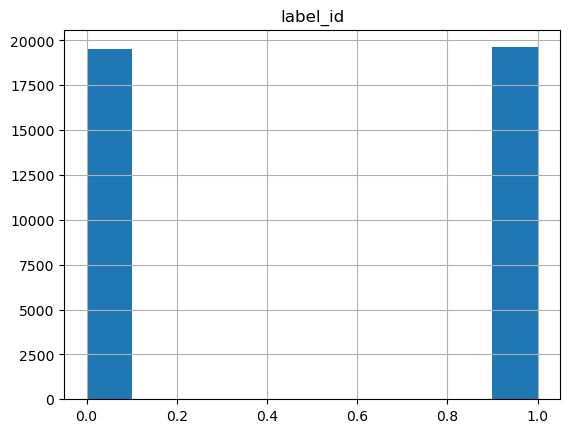

In [52]:
clean_df.hist()

In [53]:
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd

def grouped_split(
    df: pd.DataFrame,
    group_col: str = "Image_ID",
    train_size: float = 0.7,
    val_size: float = 0.15,
    test_size: float = 0.15,
    random_state: int = 42,
):
    """
    Split DataFrame into train/val/test using GroupShuffleSplit,
    keeping all rows of each group (e.g. Image_ID) in the same split.

    Args:
        df (pd.DataFrame): cleaned dataset
        group_col (str): grouping column, e.g. 'Image_ID'
        train_size (float): fraction of groups for training
        val_size (float): fraction of groups for validation
        test_size (float): fraction of groups for test
        random_state (int): reproducibility seed

    Returns:
        (train_df, val_df, test_df)
    """
    total = train_size + val_size + test_size
    if not abs(total - 1.0) < 1e-6:
        raise ValueError(f"train+val+test must sum to 1. Got {total:.2f}")

    groups = df[group_col].values

    # 🟩 Split 1: Train vs (Val+Test)
    gss1 = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
    train_idx, temp_idx = next(gss1.split(df, groups=groups))
    train_df = df.iloc[train_idx].reset_index(drop=True)
    temp_df  = df.iloc[temp_idx].reset_index(drop=True)

    # 🟨 Split 2: Val vs Test (split temp 50:50 because val=test=15%)
    gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
    val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df[group_col].values))
    val_df  = temp_df.iloc[val_idx].reset_index(drop=True)
    test_df = temp_df.iloc[test_idx].reset_index(drop=True)

    # 🧾 Summary
    print(f"✅ Split complete ({len(df):,} rows total)")
    print(f"  Train: {len(train_df):,} rows | {train_df[group_col].nunique():,} unique {group_col}s")
    print(f"  Val:   {len(val_df):,} rows | {val_df[group_col].nunique():,} unique {group_col}s")
    print(f"  Test:  {len(test_df):,} rows | {test_df[group_col].nunique():,} unique {group_col}s")

    return train_df, val_df, test_df


In [54]:
train_df, val_df, test_df = grouped_split(clean_df, group_col="Image_ID", random_state=42)

✅ Split complete (39,128 rows total)
  Train: 27,507 rows | 13,701 unique Image_IDs
  Val:   5,801 rows | 2,936 unique Image_IDs
  Test:  5,820 rows | 2,936 unique Image_IDs


In [55]:
train_df.columns

Index(['Image_ID', 'Label', 'Hypothesis', 'Premise', 'image_path', 'label_id'], dtype='object')

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

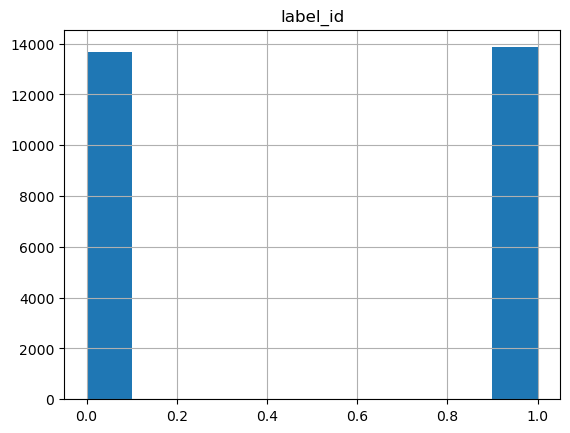

In [56]:
train_df.hist()

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

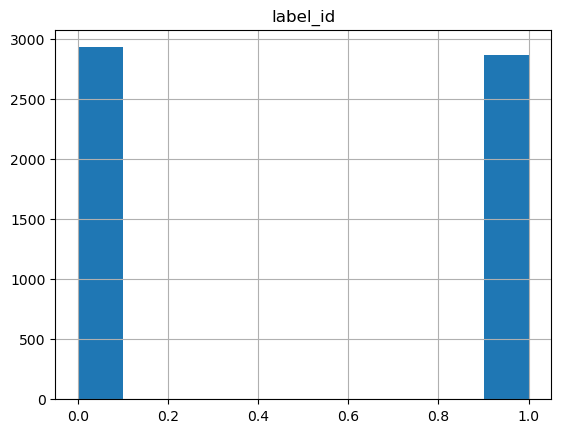

In [57]:
val_df.hist()

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

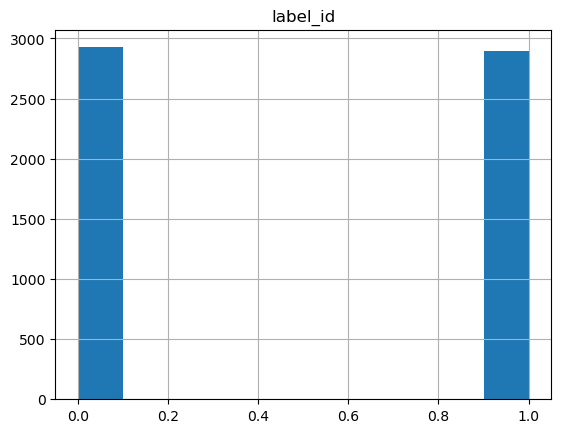

In [58]:
test_df.hist()

## Image augmenation 

In [59]:
!pip install -U keras-cv keras-nlp tfclip ftfy

## Evaluation frame work (goal:...)

In [60]:
train_df.head()

,Image_ID,Label,Hypothesis,Premise,image_path,label_id
0,4564320256,entailment,The old woman and a girl are bored.,An old woman and a young girl are sitting arou...,./A2_Data/A2_Images/4564320256.jpg,1
1,4564320256,contradiction,Two old men robbing a convenience store.,An old lady and her granddaughter working in a...,./A2_Data/A2_Images/4564320256.jpg,0
2,4564320256,contradiction,A man implies that he is very strong.,Two women sitting down reading newspapers.,./A2_Data/A2_Images/4564320256.jpg,0
3,3945005060,contradiction,People rubbing sticks to start a fire in a pit.,Three people at a library with computers.,./A2_Data/A2_Images/3945005060.jpg,0
4,369186134,entailment,Dogs are out in the snow,Three dogs next to a blue fence in the snow.,./A2_Data/A2_Images/369186134.jpg,1


In [61]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [64]:
!pip install tfclip optuna ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [optuna]2m3/4 [optuna]]


In [65]:
import os, json, hashlib, random, math, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

try:
    from tfclip import create_model_and_transforms
    TFCLIP_AVAILABLE = True
except Exception:
    print("⚠️ Install tfclip with: pip install tfclip")
    TFCLIP_AVAILABLE = False

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print("TF:", tf.__version__)

⚠️ Install tfclip with: pip install tfclip
TF: 2.16.2


In [66]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

TensorFlow version: 2.16.2
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True


In [67]:

IMAGE_SIZE    = (224,224)
BATCH_SIZE    = 32
EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 10
LR_STAGE1     = 1e-3
LR_STAGE2     = 1e-5

CLIP_MODEL_NAME = "ViT-B-32-quickgelu"
CLIP_PRETRAINED = "openai"

## 5) CLIP Preprocessors

In [68]:
train_df.columns

Index(['Image_ID', 'Label', 'Hypothesis', 'Premise', 'image_path', 'label_id'], dtype='object')

In [69]:
def harmonize_labels(train_df, val_df, test_df):
    all_labels = (
        pd.concat([train_df["Label"], val_df["Label"], test_df["Label"]])
          .astype(str).str.lower().unique()
    )
    label2id = {lbl:i for i, lbl in enumerate(sorted(all_labels))}
    id2label = {i:lbl for lbl,i in label2id.items()}
    for df_ in (train_df, val_df, test_df):
        df_["Label"] = df_["Label"].astype(str).str.lower()
        df_["label_id"] = df_["Label"].map(label2id).astype(int)
    return label2id, id2label


In [70]:
class F1Score(keras.metrics.Metric):
    """Macro/micro F1 for one-hot targets."""
    def __init__(self, num_classes, average='macro', name='f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.average = average
        self.tp = self.add_weight(shape=(num_classes,), initializer="zeros", name="tp")
        self.fpd = self.add_weight(shape=(num_classes,), initializer="zeros", name="fp")
        self.fn = self.add_weight(shape=(num_classes,), initializer="zeros", name="fn")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true_oh = tf.one_hot(y_true, depth=self.num_classes)
        y_pred_oh = tf.one_hot(y_pred, depth=self.num_classes)
        tp = tf.reduce_sum(y_true_oh * y_pred_oh, axis=0)
        fp = tf.reduce_sum((1 - y_true_oh) * y_pred_oh, axis=0)
        fn = tf.reduce_sum(y_true_oh * (1 - y_pred_oh), axis=0)
        self.tp.assign_add(tp); self.fp.assign_add(fp); self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-7)
        recall    = self.tp / (self.tp + self.fn + 1e-7)
        f1 = 2 * precision * recall / (precision + recall + 1e-7)
        if self.average == 'macro':
            return tf.reduce_mean(f1)
        elif self.average == 'micro':
            tp = tf.reduce_sum(self.tp); fp = tf.reduce_sum(self.fp); fn = tf.reduce_sum(self.fn)
            p = tp / (tp + fp + 1e-7); r = tp / (tp + fn + 1e-7)
            return 2 * p * r / (p + r + 1e-7)
        return f1

    def reset_state(self):
        for v in (self.tp, self.fp, self.fn):
            v.assign(tf.zeros_like(v))

def create_dataset(images, texts, labels, num_classes, batch_size=32, shuffle=False):
    y = tf.one_hot(labels, depth=num_classes)
    ds = tf.data.Dataset.from_tensor_slices(({"image": images, "text": texts}, y))
    if shuffle:
        ds = ds.shuffle(min(len(labels), 10000), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds
